In [1]:
import graphviz
import numpy as np
import pandas as pd
from sklearn import tree
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split 
from yellowbrick.classifier import ClassificationReport

import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('grades.csv')

In [3]:
data.head()

,PUPIL_SEX,PUPIL_CLASS,TEACHER_RIGHT,TEACHER_CHK,TEACHER_QUEST,TEACHER_CORR,PUPIL_CORR,PUPIL_STRIP,GRADE
0,F,8A,65,0,4,2,1,6,4-
1,F,8A,70,4,0,4,0,4,3
2,F,8A,85,0,0,4,3,5,4
3,M,8A,55,0,0,1,8,3,3
4,M,8A,40,1,2,0,3,4,2


In [4]:
data.isnull().sum().sort_values(ascending=False)

PUPIL_SEX        0
PUPIL_CLASS      0
TEACHER_RIGHT    0
TEACHER_CHK      0
TEACHER_QUEST    0
TEACHER_CORR     0
PUPIL_CORR       0
PUPIL_STRIP      0
GRADE            0
dtype: int64

In [5]:
X = data[['PUPIL_SEX', 
          'PUPIL_CLASS', 
          'TEACHER_RIGHT', 
          'TEACHER_CHK',
          'TEACHER_QUEST', 
          'TEACHER_CORR', 
          'PUPIL_CORR', 
          'PUPIL_STRIP']]

y = data['GRADE']

In [6]:
le = preprocessing.LabelEncoder()

X['PUPIL_SEX'] = le.fit_transform(data['PUPIL_SEX'])
print({sex: i for i, sex in enumerate(le.inverse_transform([0, 1]))})

X['PUPIL_CLASS'] = le.fit_transform(data['PUPIL_CLASS'])
print({cl: i for i, cl in enumerate(le.inverse_transform([0, 1]))})

y = le.fit_transform(data['GRADE'])
print({grade: i for i, grade in enumerate(le.inverse_transform([0, 1, 2, 3, 4, 5, 6]))})

{'F': 0, 'M': 1}
{'8A': 0, '8B': 1}
{'2': 0, '3': 1, '3-': 2, '4': 3, '4-': 4, '5': 5, '5-': 6}


In [7]:
tree_clf = tree.DecisionTreeClassifier()
tree_clf = tree_clf.fit(X, y)

In [8]:
dot_data = tree.export_graphviz(tree_clf, out_file=None,
                                feature_names=data.columns.values[:-1],
                                class_names=le.inverse_transform([0, 1, 2, 3, 4, 5, 6]),  
                                filled=True, rounded=True,  
                                special_characters=True) 
graph = graphviz.Source(dot_data) 
graph.render("grades-100") 

'grades-100.pdf'

In [9]:
def build_tree(X, y, test_size, criterion):
    class_names = le.inverse_transform([0, 1, 2, 3, 4, 5, 6])
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=5)
    
    print(y_train.shape, y_test.shape)
    
    param_grid = [{
             'max_depth':[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15], 
             'min_samples_leaf':[1, 2, 3, 4, 5, 6, 7, 8, 9, 10], 
            }]
    
    tree_clf = tree.DecisionTreeClassifier(criterion=criterion, random_state=1)
    
    grid_search = GridSearchCV(tree_clf, param_grid, cv=2, n_jobs=12)
    grid_search.fit(X_train, y_train)
    
    max_depth = grid_search.best_params_['max_depth']
    min_samples_leaf = grid_search.best_params_['min_samples_leaf']
    tree_clf_unf = tree.DecisionTreeClassifier(criterion=criterion, max_depth=max_depth, 
                                           min_samples_leaf=min_samples_leaf, 
                                           random_state=1)
    tree_clf = tree_clf_unf.fit(X_train, y_train)
    
    dot_data = tree.export_graphviz(tree_clf, out_file=None,
                                feature_names=data.columns.values[:-1],
                                class_names=class_names,  
                                filled=True, rounded=True,  
                                special_characters=True) 
    graph = graphviz.Source(dot_data) 
    graph.render(f"grades-{int(100 * (1 - test_size))}:{int(100 * test_size)}-{criterion}")
    
    
    vis = ClassificationReport(tree_clf_unf, classes=class_names)
    
    vis.fit(X_train, y_train)
    acc = vis.score(X_test, y_test)
    print(f'Accuracy {round(acc, 5)} with split = {int(100 * (1 - test_size))}:{int(100 * test_size)} and criterion = {criterion}')
    vis.show()
    print('-----------------------------------------------------------------')

(43,) (29,)
Accuracy 0.65517 with split = 60:40 and criterion = entropy


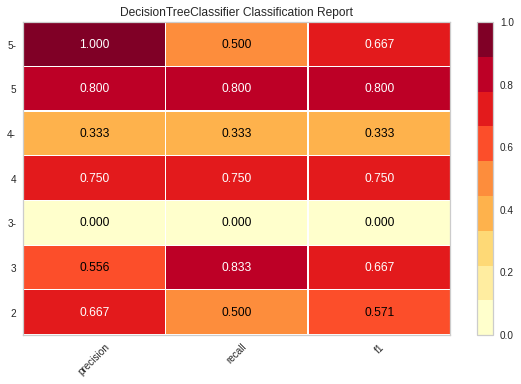

-----------------------------------------------------------------
(50,) (22,)
Accuracy 0.68182 with split = 70:30 and criterion = entropy


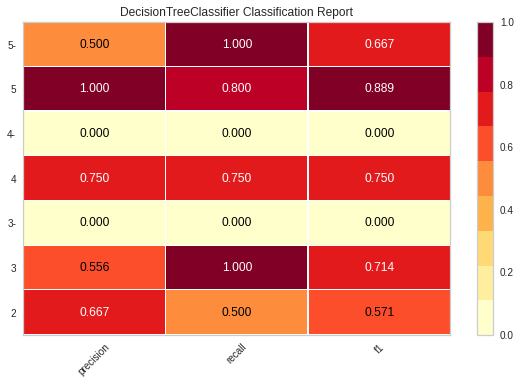

-----------------------------------------------------------------
(57,) (15,)
Accuracy 0.53333 with split = 80:20 and criterion = entropy


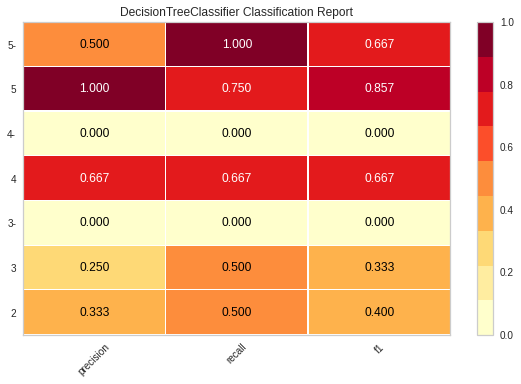

-----------------------------------------------------------------
(64,) (8,)
Accuracy 0.375 with split = 90:10 and criterion = entropy


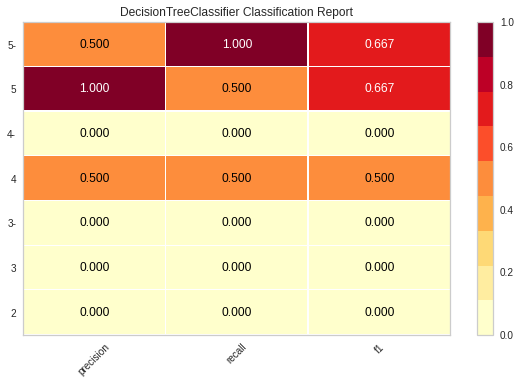

-----------------------------------------------------------------


In [10]:
for spl in range(4, 0, -1):
    build_tree(X, y, round(spl * 0.1, 1), 'entropy')

(43,) (29,)
Accuracy 0.55172 with split = 60:40 and criterion = gini


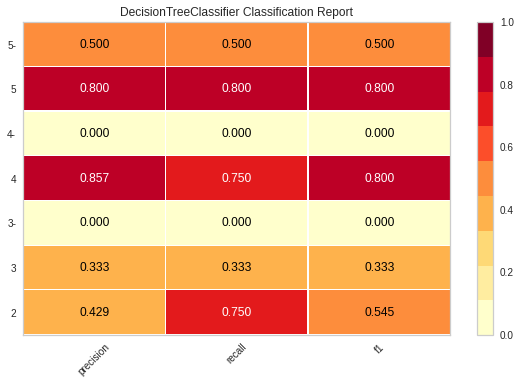

-----------------------------------------------------------------
(50,) (22,)
Accuracy 0.68182 with split = 70:30 and criterion = gini


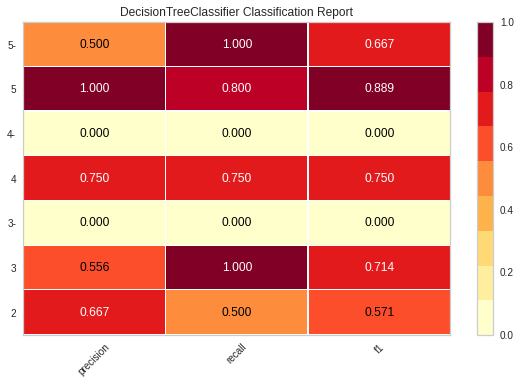

-----------------------------------------------------------------
(57,) (15,)
Accuracy 0.46667 with split = 80:20 and criterion = gini


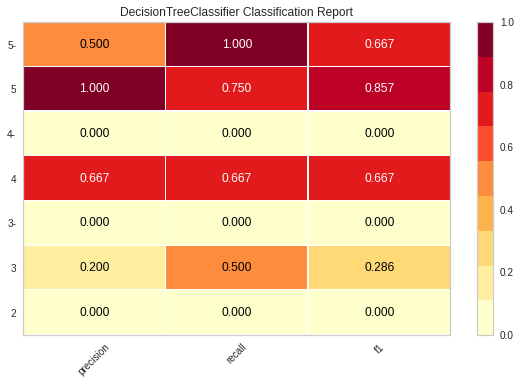

-----------------------------------------------------------------
(64,) (8,)
Accuracy 0.375 with split = 90:10 and criterion = gini


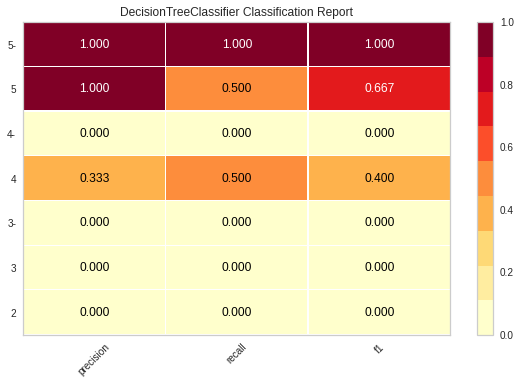

-----------------------------------------------------------------


In [11]:
for spl in range(4, 0, -1):
    build_tree(X, y, round(spl * 0.1, 1), 'gini')